<a href="https://colab.research.google.com/github/gvanhemert/DeepLearning/blob/main/DeepwaveModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install pickle5
!pip install pandas==1.3.2


     |████████████████████████████████| 132 kB 13.1 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219323 sha256=b1695b3813332e7be2e4b2f4cb3b9172659f3848c7ad81729f421c9dcad40fd8
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5
     |████████████████████████████████| 11.3 MB 12.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, Input, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle5 as pickle
from tensorflow.keras import backend as K
import locale
import math
import glob

def get_dataset_large(tfr_dir="/content/drive/MyDrive/DeepLearning/combined_data/combined_data/combined_data/", pattern:str="*combined_data.tfrecords"):
    files = glob.glob(tfr_dir+pattern, recursive=False)
    
    dataset = tf.data.TFRecordDataset(files)
    
    
    dataset = dataset.map(
        tf_parse)
    
    return dataset


def tf_parse(eg):
    """parse an example (or batch of examples, not quite sure...)"""
    
    # here we re-specify our format
    # you can also infer the format from the data using tf.train.Example.FromString
    # but that did not work
    example = tf.io.parse_example(
        eg[tf.newaxis],
        {
        'height': tf.io.FixedLenFeature([],tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'depth': tf.io.FixedLenFeature([], tf.int64),
        'bathy': tf.io.FixedLenFeature([], tf.string),
        'hs': tf.io.FixedLenFeature([], tf.string),
        'eta': tf.io.FixedLenFeature([], tf.float32),
        'zeta': tf.io.FixedLenFeature([], tf.float32),
        'theta': tf.io.FixedLenFeature([], tf.float32),
        },
    )
    bathy = tf.io.parse_tensor(example["bathy"][0], out_type="float32")
    hs = tf.io.parse_tensor(example["hs"][0], out_type="float32")
    eta = example["eta"]
    zeta = example["zeta"]
    theta = example["theta"]
    attr = tf.stack([eta,zeta,theta],axis=1)
    attr = tf.reshape(attr,shape=[-1])
    return (bathy,attr), hs

def create_mlp(dim):
    model = Sequential()
    model.add(Dense(64, input_dim=dim, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(256*256, activation='relu'))
    model.build((None, 256*256))

    return model

def create_cnn(width, height, depth):
    inputShape = (height, width, depth)
    
    inputs = Input(shape=inputShape)
    x = Conv2D(64, (3,3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    ax = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 1
    x = Conv2D(32, (3,3), padding="same")(ax)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    bx = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 2
    x = Conv2D(32, (3,3), padding="same")(bx)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    cx = MaxPooling2D(pool_size=(2,2))(x)

    #Branch 3
    x = Conv2D(32, (3,3), padding="same")(cx)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(32, (3,3), padding="same")(x)

    #Branch 2
    x = Concatenate()([x, cx])
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(32, (3,3), padding="same")(x)

    #Branch 1
    x = Concatenate()([x, bx])
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(32, (3,3), padding="same")(x)
    
    #Main Branch
    x = Concatenate()([x,ax])
    x = Conv2D(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    
    model = Model(inputs, x)
    
    return model
    
def full_model(cnn_model, mlp_model):
    
    x = cnn_model.output
    cx = mlp_model.output
    
    conv_shape = K.int_shape(x)
    
    cx = Reshape((conv_shape[1],conv_shape[2],int(conv_shape[3]/4)))(cx)
    
    x = Concatenate()([x,cx])
    
    x = Conv2D(16, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(32, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(256, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(2,2))(x)
    x = Conv2DTranspose(1, (3,3), padding="same", activation="linear")(x)
    
    model = Model(inputs=[cnn_model.input, mlp_model.input], outputs = x)
    
    return model   

dataset = get_dataset_large()

train_size = int(0.75*1016)
val_size = int(0.125*1016)
test_size = int(0.125*1016)

dataset = dataset.shuffle(buffer_size=30)
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

train_dataset = train_dataset.batch(8)
val_dataset = val_dataset.batch(8)

cnn_model = create_cnn(256, 256, 1, regress=True)
mlp_model = create_mlp(3)

model = full_model(cnn_model, mlp_model)
opt = Adam(learning_rate=1e-4, decay=1e-4/200)
model.compile(loss="mean_squared_error", optimizer=opt)

initial_learning_rate = 0.001
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 20.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

print("[INFO] training model...")
model.fit(x=train_dataset,
          validation_data=val_dataset,
          epochs=150)
          #callbacks=[LearningRateScheduler(lr_step_decay, verbose=1)])

#model.save('/content/drive/MyDrive/DeepLearning/ModelV5.h5')



57/96 [================>.............] - ETA: 16s - loss: 3.9387

KeyboardInterrupt: ignored

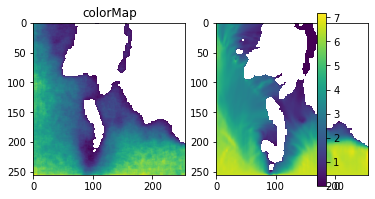

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
model = load_model('/content/drive/MyDrive/DeepLearning/ModelV11.h5', compile = True)


source = 9

Prediction = model.predict([inputImages[318:319], inputAttr[318:319]])[0][:,:,0]
Truehs = outputImages[318][:,:,0]
#Prediction = model.predict([testImgX[0:10], testAttrX[0:10]])[source][:,:,0]
Prediction[Prediction < 0] = np.nan
#Truehs = testY[source][:,:,0]
Truehs[Truehs < 0] = np.nan
#print(testAttrX[6])
fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(1,2,1)
ax.set_title('colorMap')
plt.imshow(Prediction)

qx = fig.add_subplot(1,2,2)
plt.imshow(Truehs)

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()